In [5]:
import os
import re
import time
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import random
import pybullet as p
import pybullet_data
import trimesh
import matplotlib.patches as patches
from collections import defaultdict, Counter
from utils.graph_env import set_objects
set_objects('set1')

from utils.graph_env import (
    OBJECTS,
    create_graph, plot_graph, cal_density, get_obj_sizes,
    Indices, get_obj_label, get_obj_pos, get_obj_size,
    find_target_obj,
)

def numeric_key(fn):
    # find the first run of digits in the filename
    m = re.search(r'(\d+)', fn)
    return int(m.group(1)) if m else float('inf')


# Create Object Files

In [ ]:
from utils.utils import create_obj
import shutil

def clear_files():
    for object_name in os.listdir("objects"):
        if object_name in ['sphere']:
            continue

        object_path = os.path.join("objects", object_name)
        for object_id in os.listdir(object_path):
            object_id_path = os.path.join(object_path, object_id)

            for f_name in os.listdir(object_id_path):
                f_path = os.path.join(object_id_path, f_name)

                # Remove 'assets' directory if it exists
                if f_name == "assets" and os.path.isdir(f_path):
                    try:
                        shutil.rmtree(f_path)
                        print(f"Removed directory: {f_path}")
                    except Exception as e:
                        print(f"Error removing directory {f_path}: {e}")
                    continue  # Skip further checks for this item

                # Check if it is a file (not a directory)
                if os.path.isfile(f_path):
                    # Keep only files ending with .glb or .blend
                    if not (f_name.endswith('.glb') or f_name.endswith('.blend')):
                        try:
                            os.remove(f_path)
                            print(f"Removed file: {f_path}")
                        except Exception as e:
                            print(f"Error deleting {f_path}: {e}")

object_specs = [
    ('table', 0.5, False),
    ('knife', 0.04, False),
    ('spoon', 0.04, False),
    ('fork', 0.04, False),
    ('apple', 0.2, False),
    ('banana', 0.2, False),
    ('pear', 0.2, False),
    ('mug', 0.5, True),
    ('paper-cup', 0.3, True),
    ('bowl', 0.4, True),
    ('box', 0.3, True),
    ('basket', 0.3, True),
    ('pan', 0.7, True)
]

clear_files()

for name, mass, convex in object_specs:
    create_obj(name, mass, convex)


# Find Object Sizes

In [6]:
def get_object_diameter(obj_name, body_type, object_dir="objects"):
    mesh_path = f"{object_dir}/{obj_name}/{obj_name}_{body_type}/{obj_name}_{body_type}.obj"
    mesh = trimesh.load_mesh(mesh_path)
    extents = mesh.bounding_box.extents
    diameter = np.max(extents[:2])  # XY-plane diameter
    if obj_name in ['basket', 'box']:
        diameter = (diameter + np.linalg.norm(extents[:2])) / 2
    return diameter

def compute_max_diameters(object_dir="objects"):
    p.connect(p.DIRECT)
    max_diameters = {}

    object_names = [d for d in os.listdir(object_dir) if os.path.isdir(os.path.join(object_dir, d))]

    for name in object_names:
        try:
            body_types = [
                int(folder.split("_")[-1])
                for folder in os.listdir(f"{object_dir}/{name}")
                if folder.startswith(f"{name}_")
            ]
        except Exception as e:
            print(f"Skipping {name}: {e}")
            continue

        diameters = []
        for body_type in sorted(body_types):
            try:
                diameter = get_object_diameter(name, body_type, object_dir)
                diameters.append(diameter)
            except Exception as e:
                print(f"Failed to process {name} bodyType {body_type}: {e}")
        if diameters:
            max_diameters[name] = np.round(max(diameters), 2)

    p.disconnect()
    return max_diameters

def get_obj_sizes():
	# Update sizes in OBJECTS
	max_diameters = compute_max_diameters()
	for obj in OBJECTS.values():
		name = obj["name"]
		if name in max_diameters:
			size = np.round(max_diameters[name] * 100)
			if size % 2 == 0:
				size += 1
			obj["size"] = (size, size)

	object_sizes = {k: v["size"] for k, v in OBJECTS.items()}

	return object_sizes

object_sizes = get_obj_sizes()
object_sizes

Skipping table: invalid literal for int() with base 10: '1.1'


{0: (19.0, 19.0),
 1: (19.0, 19.0),
 2: (19.0, 19.0),
 3: (9.0, 9.0),
 4: (7.0, 7.0),
 5: (17.0, 17.0),
 6: (9.0, 9.0),
 7: (13.0, 13.0),
 8: (13.0, 13.0),
 9: (25.0, 25.0),
 10: (23.0, 23.0),
 11: (27.0, 27.0)}

# Scene Create

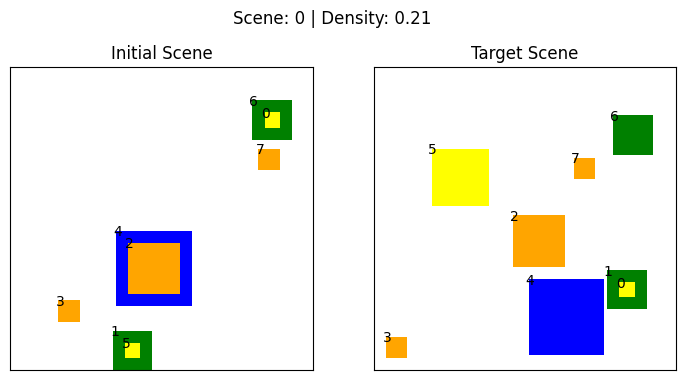

Saved scene to example_scenes/scene_0.json


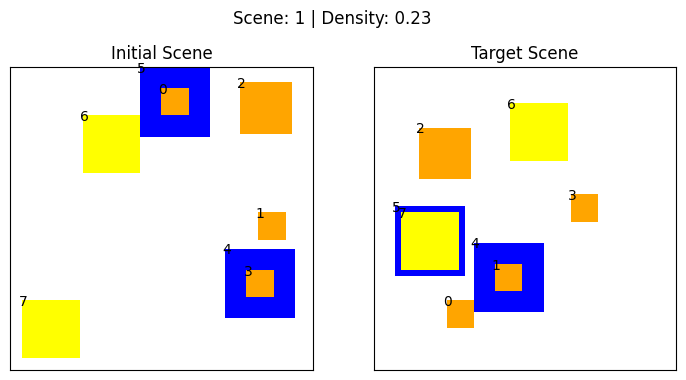

Saved scene to example_scenes/scene_1.json


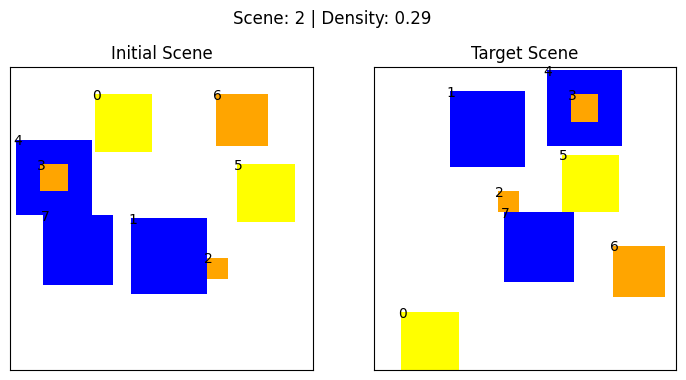

Saved scene to example_scenes/scene_2.json


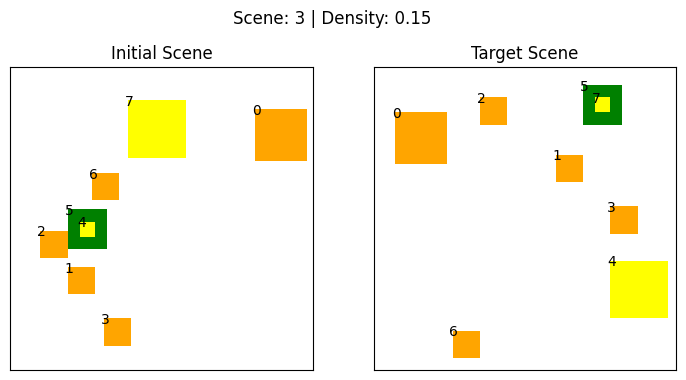

Saved scene to example_scenes/scene_3.json


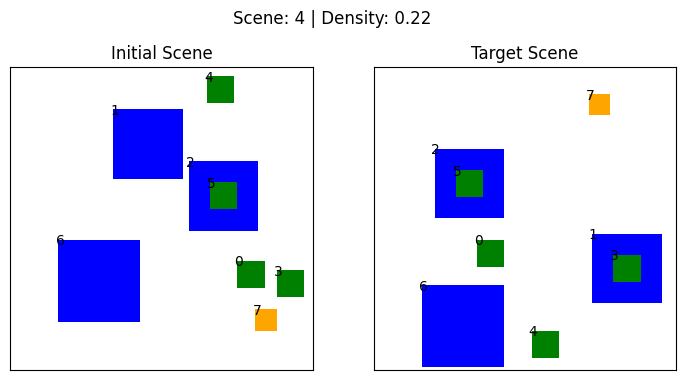

Saved scene to example_scenes/scene_4.json


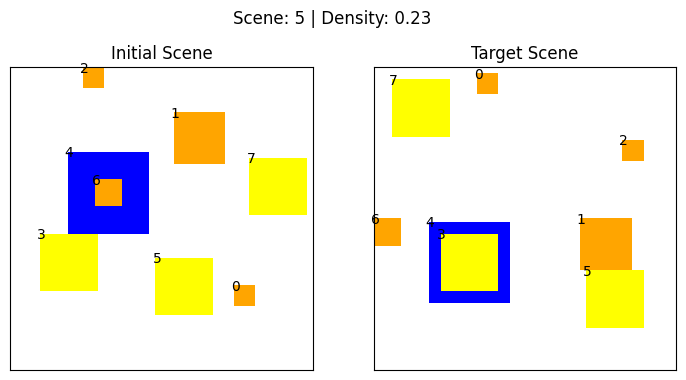

Saved scene to example_scenes/scene_5.json


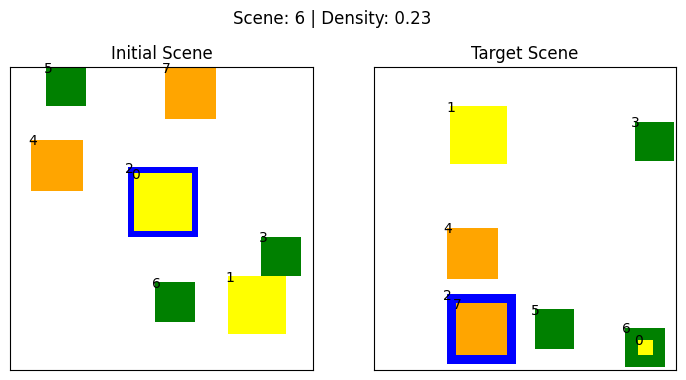

Saved scene to example_scenes/scene_6.json


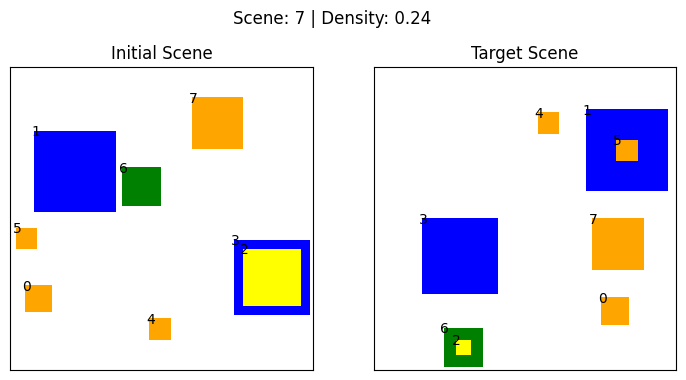

Saved scene to example_scenes/scene_7.json


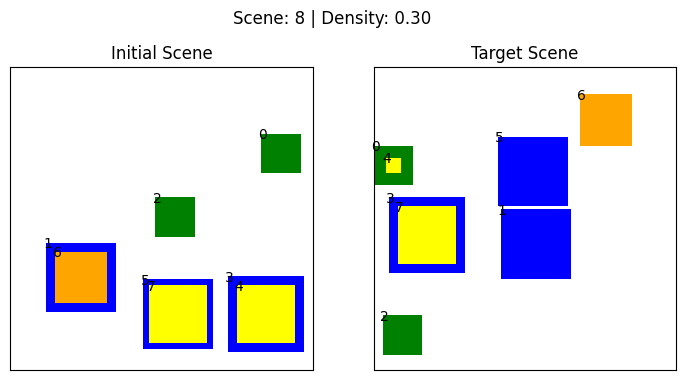

Saved scene to example_scenes/scene_8.json


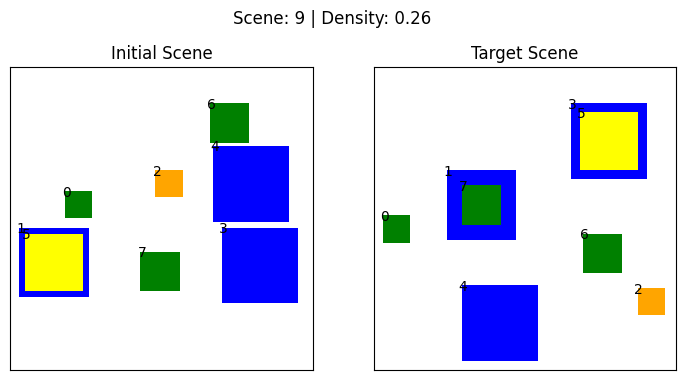

Saved scene to example_scenes/scene_9.json


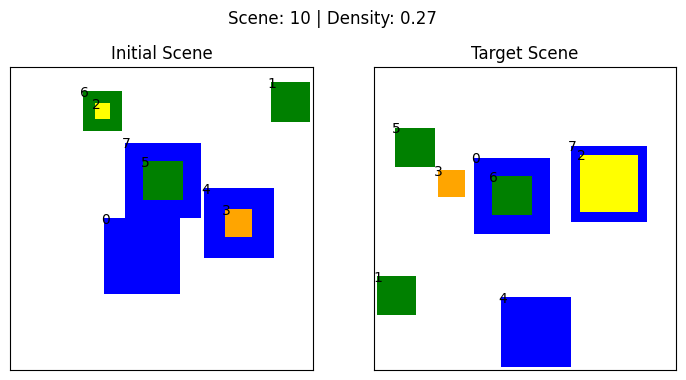

Saved scene to example_scenes/scene_10.json


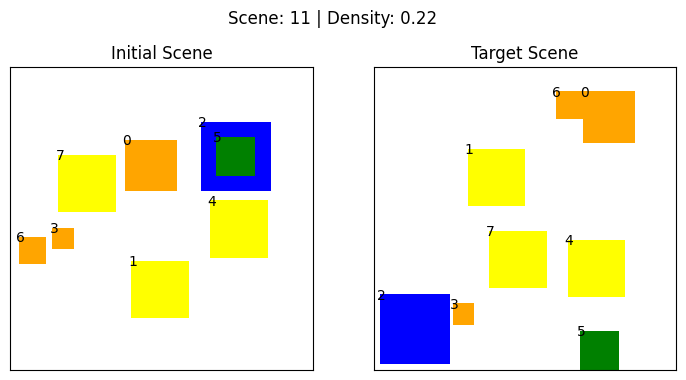

Saved scene to example_scenes/scene_11.json


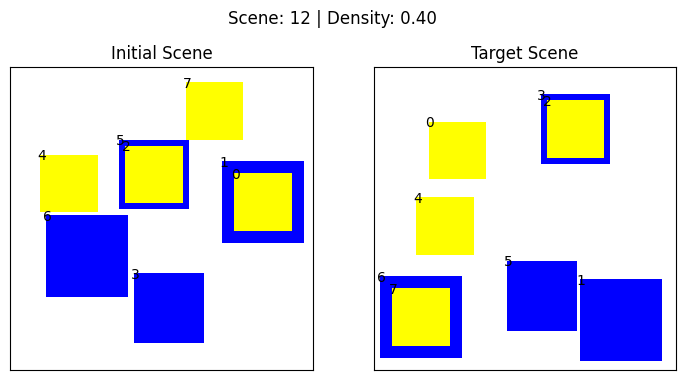

Saved scene to example_scenes/scene_12.json


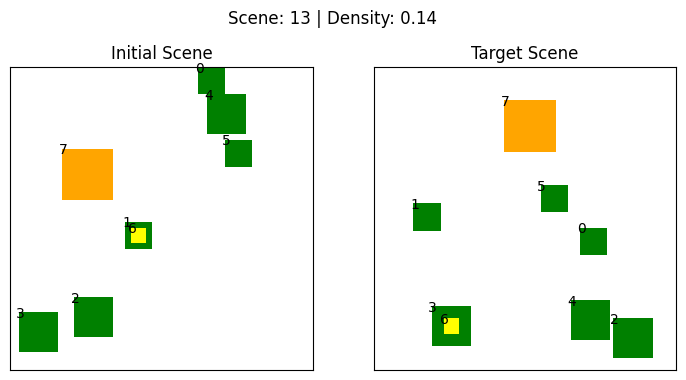

Saved scene to example_scenes/scene_13.json


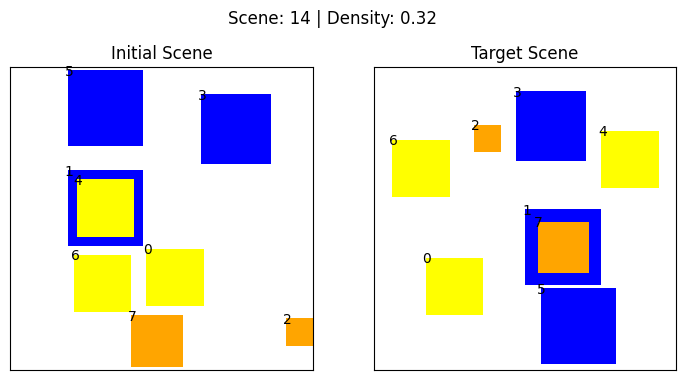

Saved scene to example_scenes/scene_14.json


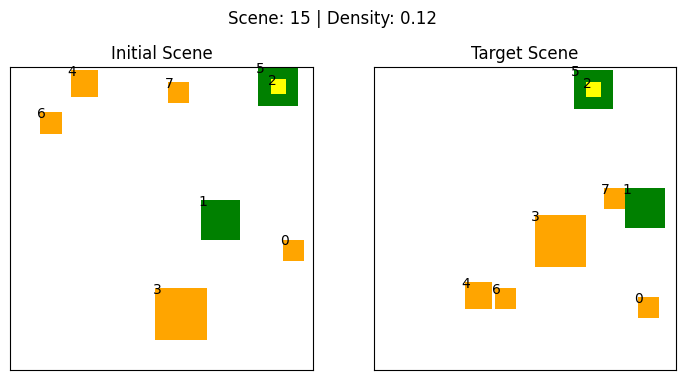

Saved scene to example_scenes/scene_15.json


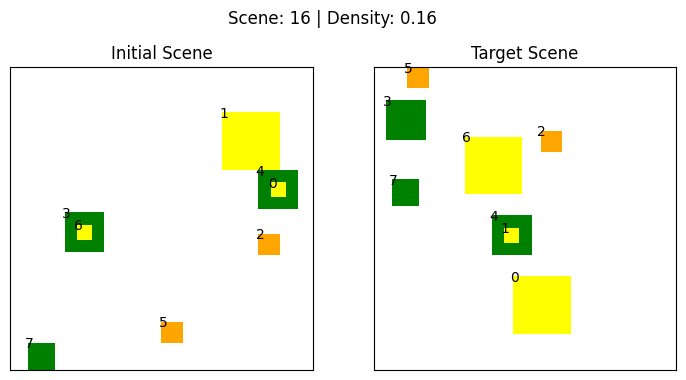

Saved scene to example_scenes/scene_16.json


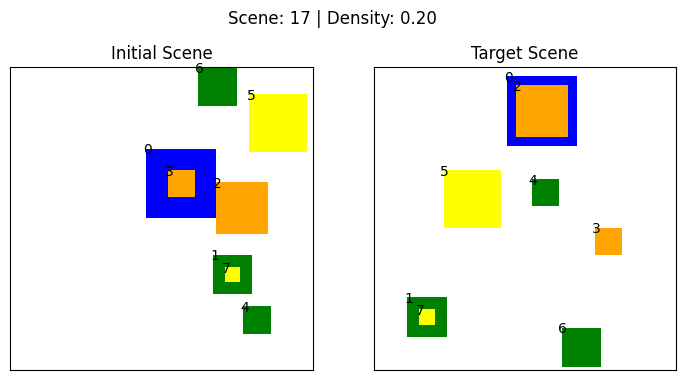

Saved scene to example_scenes/scene_17.json


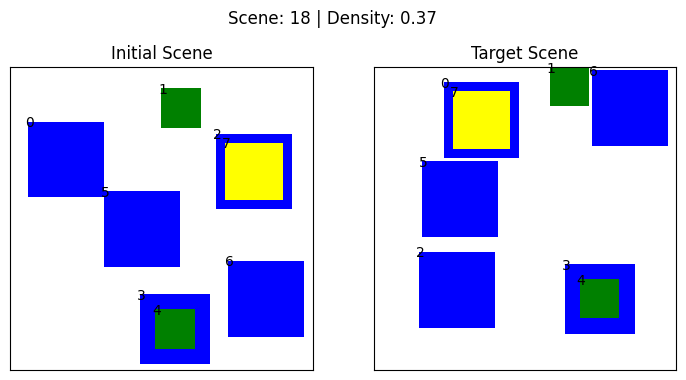

Saved scene to example_scenes/scene_18.json


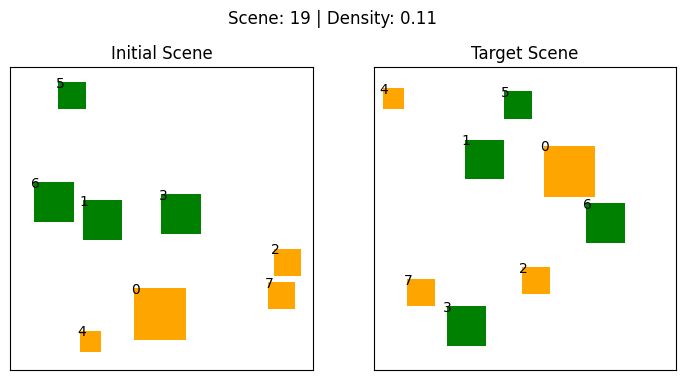

Saved scene to example_scenes/scene_19.json


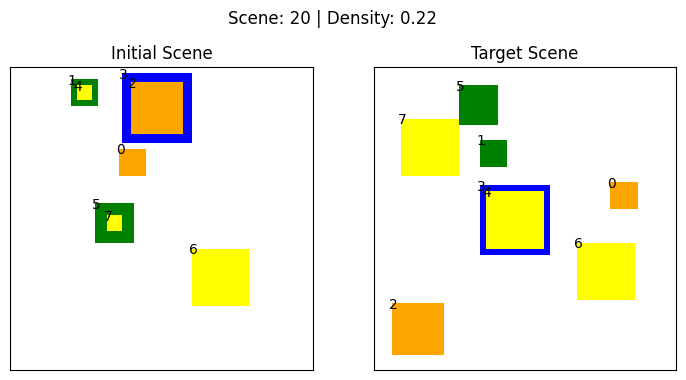

Saved scene to example_scenes/scene_20.json


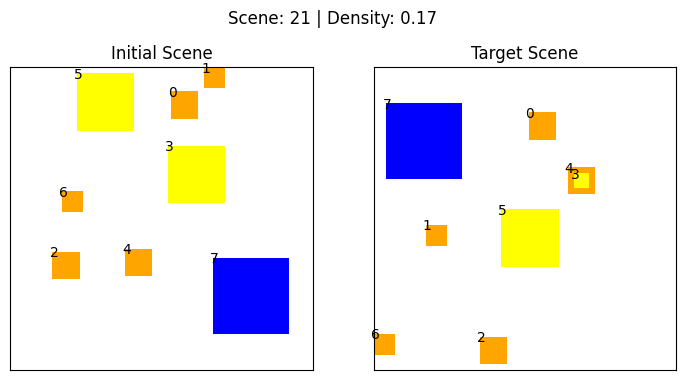

Saved scene to example_scenes/scene_21.json


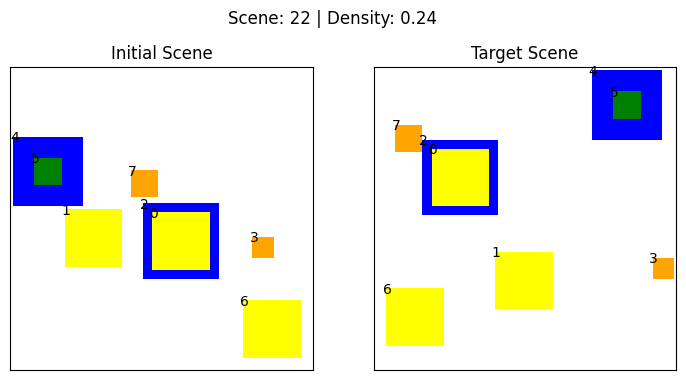

Saved scene to example_scenes/scene_22.json


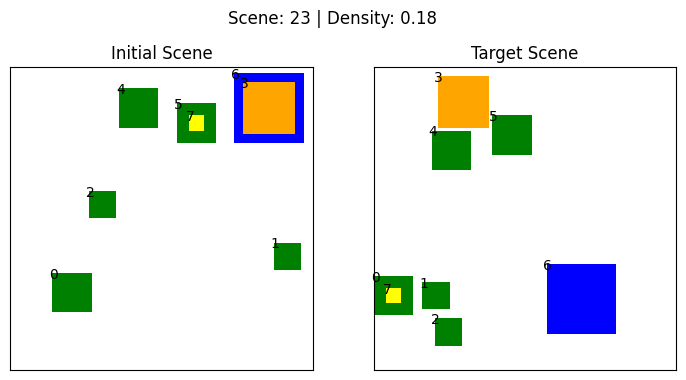

Saved scene to example_scenes/scene_23.json


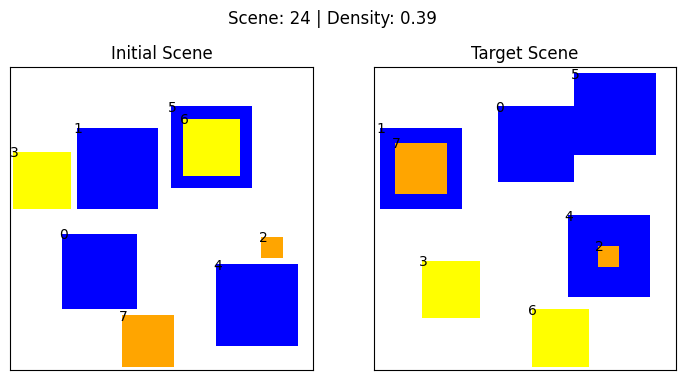

Saved scene to example_scenes/scene_24.json


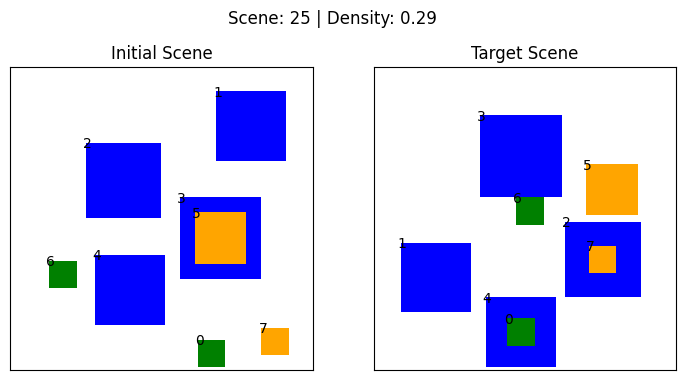

Saved scene to example_scenes/scene_25.json


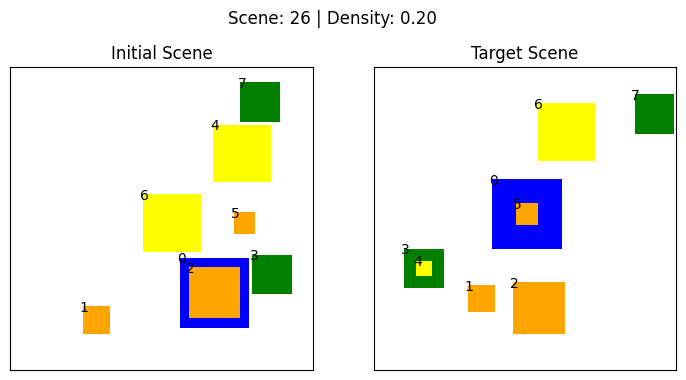

Saved scene to example_scenes/scene_26.json


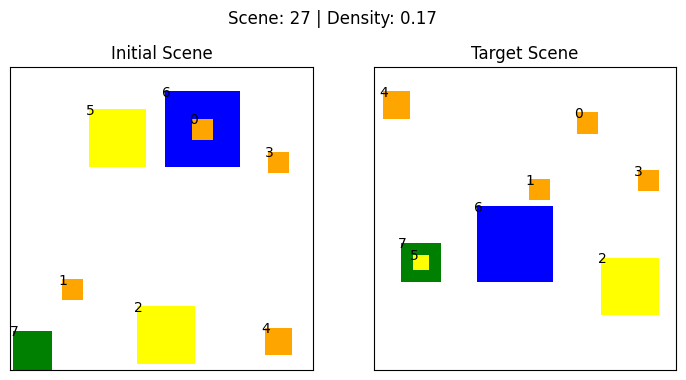

Saved scene to example_scenes/scene_27.json


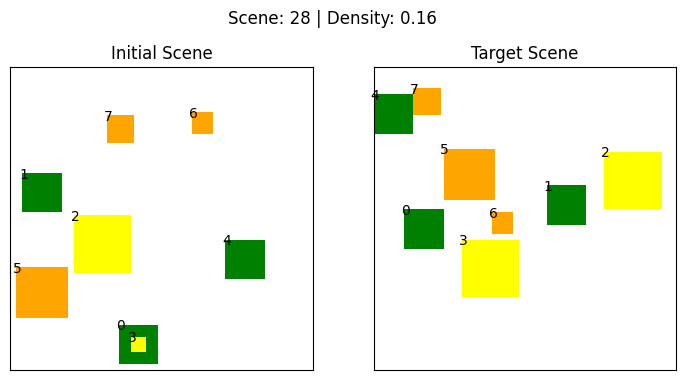

Saved scene to example_scenes/scene_28.json


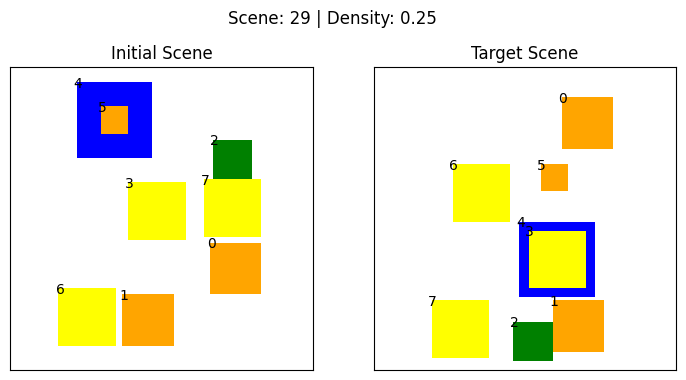

Saved scene to example_scenes/scene_29.json


In [7]:
def get_next_scene_id(dir_path):
    if not os.path.exists(dir_path):
        return 0

    scene_files = [f for f in os.listdir(dir_path) if re.match(r'scene_(\d+)\.json', f)]
    if not scene_files:
        return 0

    # Extract numbers and find max
    scene_ids = [int(re.findall(r'\d+', f)[0]) for f in scene_files]
    return max(scene_ids) + 1

def save_scene_json(dir_path, grid_size, initial_scene, target_scene, scene_id):
	os.makedirs(dir_path, exist_ok=True)

	num_objects = initial_scene.num_nodes
	
	# save the scene in a json file
	objs = []
	for obj in range(num_objects):
		objs.append({
			'object_id': obj,
			'label': get_obj_label(initial_scene.x, obj),
			'size': get_obj_size(initial_scene.x, obj),
			'initial_pos': get_obj_pos(initial_scene.x, obj).tolist(),
			'initial_base_id': find_target_obj(initial_scene.x, obj),
			'target_pos': get_obj_pos(target_scene.x, obj).tolist(),
			'target_base_id': find_target_obj(target_scene.x, obj), 
		})
	
	json_scene = {
		'scene_id': scene_id,
		'phi': cal_density(initial_scene, grid_size),
		'num_objects': num_objects,
		'grid_size': grid_size,
		'objects': objs
	}
	
	# Save the scene in a json file
	with open(f'{dir_path}/scene_{scene_id}.json', 'w') as f:
		json.dump(json_scene, f, indent=4)

	print(f'Saved scene to {dir_path}/scene_{scene_id}.json')

def create_initial_target_scenes(num_objects, grid_size, object_sizes, stack_prob):
	initial_graph = create_graph(num_objects, grid_size, len(object_sizes), object_sizes, None, stack_prob=stack_prob)

	labels = list(initial_graph.x[:, Indices.LABEL].reshape(-1).numpy())
	labels = list(map(int, labels))
	target_graph = create_graph(num_objects, grid_size, len(object_sizes), object_sizes, labels, stack_prob=stack_prob)
	while torch.equal(initial_graph.x, target_graph.x):
		target_graph = create_graph(num_objects, grid_size, len(object_sizes), object_sizes, labels, stack_prob=stack_prob)

	return initial_graph, target_graph

num_cases = 30
num_objects = 8
grid_size = (100, 100)
fig_size = 4.3

dir_path = 'example_scenes'
start_id = get_next_scene_id(dir_path)

for i in range(num_cases):
	initial_scene, target_scene = create_initial_target_scenes(num_objects, grid_size, object_sizes, stack_prob=1)
	scale = max(grid_size) / min(grid_size)
	fig, ax = plt.subplots(1, 2, figsize=(fig_size*2*scale, fig_size))
	plot_graph(initial_scene, grid_size, ax=ax[0], fig_size=fig_size, title='Initial Scene')
	plot_graph(target_scene, grid_size, ax=ax[1], fig_size=fig_size, title='Target Scene')
	plt.suptitle(f"Scene: {start_id + i} | Density: {cal_density(initial_scene, grid_size):.2f}")
	plt.show()
	save_scene_json(dir_path, grid_size, initial_scene, target_scene, start_id + i)


# Simulation

In [8]:
def random_pos(x_range, y_range, z_range):
    return [
        random.uniform(*x_range),
        random.uniform(*y_range),
        random.uniform(*z_range)
    ]

def load_object(name, pos, orn=[0, 0, 0], scale=1, bodyType=None, verbose=0):
    if bodyType is None:
        bodyType = random.randint(1, len(os.listdir(f"objects/{name}")))
    urdf_path = f"objects/{name}/{name}_{bodyType}/{name}_{bodyType}.urdf"
    orn = p.getQuaternionFromEuler(orn)
    bodyId = p.loadURDF(urdf_path, pos, orn, useFixedBase=False,
                        globalScaling=scale, flags=p.URDF_USE_MATERIAL_COLORS_FROM_MTL)
    p.changeVisualShape(bodyId, -1, rgbaColor=[1, 1, 1, 1])
    if verbose:
        print(f"Loaded object {name} at {pos}")
    return bodyId, bodyType

def load_table(gridSize, pos=[0, 0, 0], verbose=0):
    if gridSize == (100, 100):
        file_path = "objects/table/table_1.1/table_1.1.urdf"
    elif gridSize == (100, 300):
        file_path = "objects/table/table_1.3/table_1.3.urdf"
    else:
        raise ValueError("Invalid grid size. Supported sizes are (100, 100) and (100, 300).")
    bodyId = p.loadURDF(file_path, pos, useFixedBase=True)
    p.changeVisualShape(bodyId, -1, rgbaColor=[1, 1, 1, 1])
    if verbose > 0:
        print(f"Loaded table with grid size {gridSize}")
    return bodyId

def get_size(obj_id):
	# Get the bounding box of the object
	bounding_box = p.getAABB(obj_id)
	# Calculate the size of the bounding box
	size = np.array(bounding_box[1]) - np.array(bounding_box[0])
	return size

def map_position(pos, x_range, y_range, grid_scale=0.01):
    x, y = pos

    # Map x
    new_x_min, new_x_max = x_range
    new_x = x * grid_scale * (new_x_max - new_x_min) + new_x_min

    # Map y
    new_y_min, new_y_max = y_range
    new_y = y * grid_scale * (new_y_max - new_y_min) + new_y_min

    return new_x, new_y

def random_tilt(pos, orn, max_shift=0.05, shift_end=False, tilt_angle=10):
	"""
	Randomly shifts x and y coordinates and tilts the orientation 
	opposite to the shift direction.
	"""
	x0, y0, z0 = pos
	roll0, pitch0, yaw0 = orn

	if shift_end:
		# Pick a random angle and place shift on the circle
		theta = np.random.uniform(0, 2 * np.pi)
		dx = max_shift * np.cos(theta)
		dy = max_shift * np.sin(theta)
	else:
		# Uniform random in the square [-max_shift, +max_shift]
		dx = np.random.uniform(-max_shift, max_shift)
		dy = np.random.uniform(-max_shift, max_shift)

	new_pos = np.array([x0 + dx, y0 + dy, z0])

	# Compute opposite tilt direction
	opposite_dir = np.array([-dx, -dy, 0])
	if np.linalg.norm(opposite_dir) > 1e-6:
		opposite_dir = opposite_dir / np.linalg.norm(opposite_dir)  # normalize

	# Apply tilt proportional to displacement
	tilt_roll = -opposite_dir[1] * np.deg2rad(tilt_angle)  # around x-axis
	tilt_pitch = opposite_dir[0] * np.deg2rad(tilt_angle)  # around y-axis

	# New orientation by adding tilt to initial
	new_orn = np.array([roll0 + tilt_roll, pitch0 + tilt_pitch, yaw0])

	return new_pos, new_orn

class PyBulletSim:
	def __init__(self, mode=p.DIRECT):
		try:
			p.disconnect()
		except:
			pass
		
		if mode == p.DIRECT:
			self.client = p.connect(p.DIRECT, options="--egl")
		else:
			self.client = p.connect(mode)
			
		p.setPhysicsEngineParameter(enableFileCaching=0)
		p.setAdditionalSearchPath(pybullet_data.getDataPath())
		p.resetSimulation()
		p.setGravity(0, 0, -9.8)
		p.setRealTimeSimulation(0)
		p.configureDebugVisualizer(p.COV_ENABLE_SHADOWS, 1)
		p.loadURDF("plane.urdf")

		self.time_step = p.getPhysicsEngineParameters()['fixedTimeStep']

	def step(self, duration=0):
		for _ in range(int(duration / self.time_step)):
			p.stepSimulation()

	def close(self):
		if p.getConnectionInfo(self.client)['connectionMethod'] == p.GUI:
			while p.isConnected():
				p.stepSimulation()
				time.sleep(self.time_step)
		try:
			p.disconnect()
		except:
			pass

class Camera:
	def __init__(self, target_pos, distance, yaw, pitch, roll, width=640, height=480,
					near=0.01, far=100, fov=60):
		self.target = target_pos
		self.distance = distance
		self.yaw, self.pitch, self.roll = yaw, pitch, roll
		self.width, self.height = width, height
		self.near, self.far = near, far
		self.fov = fov
		self.up_axis = 2

		p.resetDebugVisualizerCamera(
			cameraDistance=distance, 
			cameraTargetPosition=target_pos, 
			cameraYaw=yaw, cameraPitch=pitch
		)

		self.view_matrix = p.computeViewMatrixFromYawPitchRoll(
			self.target, self.distance, self.yaw, self.pitch, self.roll, self.up_axis)
		self.proj_matrix = p.computeProjectionMatrixFOV(
			self.fov, self.width/self.height, self.near, self.far)

		self.V = np.array(self.view_matrix).reshape(4, 4, order='F')
		self.P = np.array(self.proj_matrix).reshape(4, 4, order='F')

	def capture_image(self):
		_, _, rgb, _, _ = p.getCameraImage(
			self.width, self.height,
			viewMatrix=self.view_matrix,
			projectionMatrix=self.proj_matrix,
			shadow=True,
			renderer=p.ER_BULLET_HARDWARE_OPENGL)
		rgba = np.reshape(rgb, (self.height, self.width, 4)).astype(np.uint8)
		return rgba[:, :, :3]

	def project_points(self, world_points):
		N = world_points.shape[0]
		clip_pts = self.P @ (self.V @ np.vstack([world_points.T, np.ones(N)]))
		ndc = clip_pts / clip_pts[3]
		u = (ndc[0]*0.5 + 0.5) * self.width
		v = (1 - (ndc[1]*0.5 + 0.5)) * self.height
		return u, v

	def compute_bounding_box(self, bodyId, bodyName, bodyType, numSamples=200):
		mesh_path = f"objects/{bodyName}/{bodyName}_{bodyType}/{bodyName}_{bodyType}.obj"
		mesh = trimesh.load_mesh(mesh_path)
		points, _ = trimesh.sample.sample_surface(mesh, numSamples)
		pos, orn = p.getBasePositionAndOrientation(bodyId)
		R = trimesh.transformations.quaternion_matrix([orn[3], *orn[:3]])[:3, :3]
		world_pts = (R @ points.T).T + np.array(pos)
		u, v = self.project_points(world_pts)
		u_min, u_max = np.floor(u.min()).astype(int), np.ceil(u.max()).astype(int)
		v_min, v_max = np.floor(v.min()).astype(int), np.ceil(v.max()).astype(int)
		return (u_min, u_max, v_min, v_max)

	def show_img(self, image, title=''):
		fig, ax = plt.subplots(figsize=(self.width / 100, self.height / 100), dpi=100)
		ax.imshow(image)
		plt.title(title)
		plt.axis('off')
		plt.show()

	def draw_bounding_boxes(self, image, boxes=[], labels=[], color='yellow', title=''):
		fig, axs = plt.subplots(1, 2, figsize=(2 * self.width / 100, self.height / 100), dpi=100)

		# Subplot 1: Raw image
		axs[0].imshow(image)
		axs[0].set_title("Raw Image")
		axs[0].axis('off')

		# Subplot 2: Image with bounding boxes
		axs[1].imshow(image)
		axs[1].set_title("Image with Bounding Boxes")
		for i, (u_min, u_max, v_min, v_max) in enumerate(boxes):
			rect = patches.Rectangle(
				(u_min, v_min), u_max - u_min, v_max - v_min,
				linewidth=2, edgecolor=color, facecolor='none'
			)
			axs[1].add_patch(rect)
			if labels and i < len(labels):
				axs[1].text(u_min, v_min - 5, labels[i], color=color,
							fontsize=10, backgroundcolor='black')
		axs[1].axis('off')
		
		plt.suptitle(title)
		plt.tight_layout()
		plt.show()

# sim = PyBulletSim(p.GUI)
# cam = Camera(target_pos=[0, 0, 0.1], distance=0.1, yaw=90, pitch=-45, roll=0)

# load_object('basket', [0, -0.3, 0.05], bodyType=1)
# load_object('basket', [0, 0, 0.05], bodyType=2)
# load_object('basket', [0, 0.3, 0.05], bodyType=3)

# sim.step(5)
# cam.show_img(cam.capture_image())
# sim.close()

In [10]:
def get_available_body_types(objects):
    available = {}
    for obj in objects:
        model_name = obj['model_name']
        if model_name not in available:
            available[model_name] = len(os.listdir(f"objects/{model_name}"))
    return available

def choose_least_used_body_type(model_name, available_body_types, counter):
    count = counter[model_name]
    num_types = available_body_types[model_name]
    min_used = min(count.get(bt, 0) for bt in range(1, num_types + 1))
    candidates = [bt for bt in range(1, num_types + 1) if count.get(bt, 0) == min_used]
    chosen = random.choice(candidates)
    counter[model_name][chosen] += 1
    return chosen

def compute_position_and_orientation(obj, objects, base_z):
	stack_hierarchy = 0
	j = obj['base_id']
	while j is not None:
		stack_hierarchy += 1
		j = objects[j]['base_id']

	pos = [obj['pos'][0], obj['pos'][1], base_z + 0.05 + 0.085 * stack_hierarchy]
	orn = [0, 0, 0]

	if stack_hierarchy > 0 and obj['label'] in [0, 1, 2]:
		orn[0] = np.pi / 2
		j = obj['base_id']
		if objects[j]['label'] in [6, 7]:
			pos, orn = random_tilt(pos, orn, max_shift=0.01, tilt_angle=10)
		elif objects[j]['label'] == 8:
			pos, orn = random_tilt(pos, orn, max_shift=0.02, shift_end=True, tilt_angle=15)
		else:
			orn[2] = random.uniform(0, 2 * np.pi)
	else:
		orn[2] = random.uniform(0, 2 * np.pi)

	return pos, orn

output_dir = "Scene_Dataset"
scene_files = os.listdir("example_scenes")
scene_files = sorted(scene_files, key=numeric_key)

progress = tqdm(scene_files, desc="Processing scenes")
for scene_path in progress:
	with open(os.path.join("example_scenes", scene_path)) as f:
		scene = json.load(f)

	scene_id = scene['scene_id']
	num_objects = scene['num_objects']
	img_path  = os.path.join(output_dir, f"scene_{scene_id}_n{num_objects}.png")
	json_path = os.path.join(output_dir, f"scene_{scene_id}_n{num_objects}.json")

	if os.path.exists(img_path) and os.path.exists(json_path):
		progress.set_postfix({"status": f"Skipped {scene_id}"})
		continue

	# sim = PyBulletSim(p.GUI)
	sim = PyBulletSim(p.DIRECT)
	table = load_table((100, 100))
	_, _, z = get_size(table)
	x_range, y_range = [-0.5, 0.5], [-0.5, 0.5]
	cam = Camera(target_pos=[0.6, 0, 1.3], distance=0.2, yaw=90, pitch=-50, roll=0)

	objects = []
	for i, obj in enumerate(scene['objects']):
		label = int(obj['label'])
		model_name = OBJECTS[label]['name']
		objects.append({
			'object_id': i,
			'label': label,
			'model_name': model_name,
			'pos': map_position(obj['initial_pos'], x_range, y_range),
			'base_id': obj['initial_base_id'],
		})

	available_body_types = get_available_body_types(objects)
	body_type_counter = defaultdict(Counter)

	for obj in objects:
		model_name = obj['model_name']
		pos, orn = compute_position_and_orientation(obj, objects, z)
		chosen_type = choose_least_used_body_type(model_name, available_body_types, body_type_counter)
		body_id, _ = load_object(model_name, pos, orn, bodyType=chosen_type)

		obj['body_id'] = body_id
		obj['body_type'] = chosen_type

	sim.step(5)

	json_data = []
	for obj in objects:
		bbox = cam.compute_bounding_box(obj['body_id'], obj['model_name'], obj['body_type'])
		pos, orn = p.getBasePositionAndOrientation(obj['body_id'])
		euler = p.getEulerFromQuaternion(orn)
		json_data.append({
			"model_name": obj['model_name'],
			"model_id": f"{obj['model_name']}_{obj['body_type']}",
			"obj_id": int(obj['object_id']),
			"6D_pose": [float(x) for x in (pos + euler)],
			"natural_parent_list": [int(obj['base_id'])] if obj['base_id'] is not None else [],
			"bbox": [float(x) for x in bbox],
		})

	image = cam.capture_image()
	img = Image.fromarray(image)
	os.makedirs(output_dir, exist_ok=True)
	img.save(img_path)

	with open(json_path, 'w') as f:
		json.dump(json_data, f, indent=4)

	progress.set_postfix({"status": f"Saved {scene_id}"})
	sim.close()

progress.close()

Processing scenes: 100%|██████████| 30/30 [02:07<00:00,  4.25s/it, status=Saved 29]
